# Binary star evolution and binary black holes
**Authors:**
- (2054778) Amico Tommaso
- (2045247) Lazzari Andrea
- (2053062) Zinesi Paolo
- (2058479) Zomer Nicola

## Introduction
A Binary Black Hole (BBH) can originate from the evolution of a massive binary star. If the binary is tight enough, it will evolve through several complex physical processes: the two stars can exchange mass either via **Stable Mass Transfer (SMT)** or via a **Common Envelope (CE)**.

Mass transfer is mainly driven by Roche-lobe filling, as this process is usually more efficient than wind accretion. The Roche lobe of a star in a binary system is a teardrop-shaped equipotential surface surrounding the star. Mass transfer occurs when a star overfills its Roche lobe, i.e. when its radius becomes larger than the Roche lobe, and it changes:
- the mass of each star
- the final mass of the compact remnants
- orbital properties of the binary (e.g. the semi-major axis)

<div>
<img src="Roche_lobe_overflow.jpg" width="700"/>
</div>

If mass transfer becomes unstable (e.g. both stars fill Roche lobe), the two stars enter a Common Envelope phase: the binary system is embedded in a gaseous, non-corotating envelope and the two members spiral in due to the gas drag exerted by the envelope. Part of the orbital energy lost as an effect of this drag is likely converted into heating of the envelope, making it more loosely bound, and this process can lead to the ejection of the envelope.

<div>
<img src="common_envelope.png" width="700"/>
</div>

To describe a common envelope, the most common formalism is the $\alpha$ formalism, where $\alpha$ is a dimensionless parameter that measures the fraction of the removed orbital energy that is transferred to the envelope, so the efficiency with which the CE is expelled. A large alpha means that the envelope is easily ejected, while a small alpha means that it takes a lot of energy to be expelled.

The simulated system can have an apparently unphysical value of $\alpha>1$, due to the fact that this simple formalism poorly describes the physics of CE, so in a full discussion the orbital energy is only one of the energy sources that partecipate in the envelope ejection.

## Goal of the project <a class="anchor" id="chapter1"></a>
Understand the differences between binary black hole mergers whose progenitors evolved via common envelope and binary black hole mergers whose progenitors evolved via stable mass transfer, by looking at a set of simulated binary black holes.

## Datasets 

Datasets are stored on Google Drive at this [link](https://drive.google.com/drive/folders/1RZGrL6RrKYKaPu0VJ7BQDXptb7B_QOLg). The tar file stable_MT_vs_CE.tgz contains 4 folders (A0.5, A1, A3 and A5). Each of them corresponds to the outputs of a set of simulations of binary black holes, which differ only by one parameter: the value of the parameter $\alpha$ ($\alpha$=0.5, 1, 3, 5) associated with the efficiency of common envelope.

Inside each folder, there are 12 files, named MTCE_BBHs_*.txt, where * is a number ranging from 0.0002 to 0.02 and represents the stellar metallicity at which the black holes where produced in the simulations.

Each row contains the properties of one simulated binary black hole. The most important columns (properties) for this analysis are:
- Column 1: initial mass (ZAMS mass) of the primary member of the binary system in Msun
- Column 2: initial mass (ZAMS mass) of the secondary member of the binary system in Msun
- Column 3: mass of the black hole that forms from the primary member (Msun)
- Column 4: mass of the black hole that forms from the secondary member (Msun)
- Column 6: delay time, i.e. time elapsed from the formation of the binary system to the merger of the two black holes (in Myr)
- Column 7: semi-major axis of the binary system at the formation of the second-born black hole (in solar radii, Rsun = 6.95e10 cm)
- Column 8: orbital eccentricity of the binary system at the formation of the second-born black hole
- **Column 21: Boolean variable indicating whether the binary system undergoes a common envelope (True). If column 21 is False, the binary goes via stable mass transfer instead of a common envelope.**

We then added 4 extra columns to the dataframe: 
- Metallicity
- Alpha ($\alpha$)
- Column Extra 1: inital mass ratio (ZAMS mass of the primary / ZAMS mass of the secondary)
- Column Extra 2: mass ratio of the black holes (mass of the BH that forms from the primary / mass of the BH that forms from the secondary)


## Creation of the dataframe

In [1]:
import pandas as pd
import numpy as np
import string
import glob
import os
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy import linalg as la
from IPython.display import display
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

In [2]:
# personalized computer settings

hname = os.getlogin()
path = ''

if hname=='paolozinesi': path = '/Users/paolozinesi/Desktop/Magistrale/a.a.2021_2022/Project_LCP_A/stable_MT_vs_CE/'
if hname=='tommaso': path = "/Users/tommaso/Desktop/MagistraleI/TheFormationOfBinaryBlackHoles_data/lab_data/stable_MT_vs_CE/"
if hname=='Nicola': path = "/Users/Nicola/data/TheFormationOfBinaryBlackHoles_data/stable_MT_vs_CE/"
if hname=='ilazza': path = "/home/ilazza/Documenti/UNIPD/TheFormationOfBinaryBlackHoles/stable_MT_vs_CE/"

In [3]:
alpha_values = [0.5, 1, 3, 5]
met_values = [0.02, 0.002, 0.0002, 0.004, 0.0004, 0.006, 0.008, 0.012, 0.0012, 0.016, 0.0016]
columns=['col.0:ID','col.1:m1ZAMS/Msun', 'col.2:m2ZAMS/Msun', 'col.3:m1rem/Msun','col.4:m2rem/Msun',  'col.6:delay_time/Myr', 'col.7:sma/Rsun', 'col.8:ecc', 'col.21:CE']
frame = pd.DataFrame(data=None, columns=columns)

for alpha in alpha_values:
    for met in met_values:
        for name in glob.glob(path+f'A{alpha}/MTCE_BBHs_{met}*'):
            df = pd.read_csv(name, skiprows=2, header=0, sep=' ')
            df = df.loc[:,columns]
            met_array = np.ones((df.shape[0], 1))*met
            alpha_array = np.ones((df.shape[0],1))*alpha
            df['metallicity'] = met_array
            df['alpha'] = alpha_array
            
            frame = pd.concat([frame, df], axis=0, ignore_index=True)
            
frame['colExt1:ratio_m1_m2_ZAMS'] = frame['col.1:m1ZAMS/Msun']/frame['col.2:m2ZAMS/Msun']
frame['colExt2:ratio_m1_m2_rem'] = frame['col.3:m1rem/Msun']/frame['col.4:m2rem/Msun']


In [4]:
frame.head()

,col.0:ID,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha,colExt1:ratio_m1_m2_ZAMS,colExt2:ratio_m1_m2_rem
0,0_6942,50.9151,50.8356,4.8001,4.7478,2233.6292,7.9524,0.273150,True,0.02,0.5,1.001564,1.011016
1,0_80347,57.0253,56.9464,5.5849,5.5325,1076.5703,9.0222,0.508320,True,0.02,0.5,1.001386,1.009471
2,0_158611,91.0594,90.7083,8.3787,8.2624,6810.4365,14.9810,0.072798,True,0.02,0.5,1.003871,1.014076
3,0_211410,117.9396,57.6917,19.3984,11.2422,7905.6343,11229.0000,0.999640,False,0.02,0.5,2.044308,1.725499
4,0_213101,40.2965,40.2439,3.1045,3.0769,8703.5479,13.7630,0.705290,True,0.02,0.5,1.001307,1.008970


In [5]:
#Creating the a dataframe with common envelopes and one with mass transfer
frame_true = frame[(frame['col.21:CE'] == True)] 
frame_true = frame_true.reset_index(drop=True)
frame_false = frame[(frame['col.21:CE'] == False)] 
frame_false = frame_false.reset_index(drop=True)

## ML algorithms

In order to extract the most important features from our data, we run some Machine Learning (ML) algorithms on the dataset. We focused only on the columns showed in the "Dataset" paragraph above, plus metallicity, alpha and the two extra columns containing the ratio of the masses.

In particular, we compared **Random Forest (RF)** and **Support Vector Machines (SVM)** algorithms in the classification of the process behind the formation of the BBH progenitors. We analyzed at first a small set of data with equal number of CE and SMT samples, eventually performing a Principal Component Analysis (PCA) to reduce the dimensionality of the dataset with little loss of information. However, even within this small dataset the most important features show up very clearly. Then we run the same ML algorithms in the whole dataset, obtaining similar results but with a more accurate estimation of the algorithm performances on the test data. Note that the full dataset has a different number of CE and SMT samples, while the limited dataset contains the same number of CE and SMT samples by construction.

### Limited data

In [6]:
# create training and test set
m_train = 20000
m_test = 1000

frame_sample = pd.concat([frame_true.sample(n=int(0.5*(m_train+m_test))),
                          frame_false.sample(n=int(0.5*(m_train+m_test)))], ignore_index=True)

frame_sample = frame_sample.sample(frac=1, ignore_index=True)
frame_train = frame_sample.iloc[:m_train]
frame_test = frame_sample.iloc[-m_test:]

# separate dataframes
lbl = {False:'SMT', True:'CE'}
X_train = frame_train.drop(labels=["col.0:ID","col.21:CE"], axis=1)
Y_train = frame_train["col.21:CE"].apply(lambda x: lbl[x])
X_test = frame_test.drop(labels=["col.0:ID","col.21:CE"], axis=1)
Y_test = frame_test["col.21:CE"].apply(lambda x: lbl[x])

### PCA

In [7]:
# DATA NORMALIZATION
# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_train)

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
pd.set_option("chop_threshold", 1e-08)

X_train_ = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
df_tmp = pd.DataFrame(np.around(pd.concat([X_train_.mean(axis=0), X_train_.std(axis=0)], axis=1), 3))
df_tmp.columns = ['mean','std']
print ("\nMean and std of the training input data:")
display(df_tmp)

X_test_ = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns) # use the same transformation on test data
# df_tmp = pd.DataFrame(np.around(pd.concat([X_test_.mean(axis=0), X_test_.std(axis=0)], axis=1), 3))
# df_tmp.columns = ['mean','std']
# print ("\nMean and std of the test input data:")
# display(df_tmp)

# PCA
data_PCA = X_train_.values.T
# eigenvectors and eigenvalues using SVD
U, spectrum, Vt = la.svd(data_PCA)
V = U                          # eigenvectors matrix
l = spectrum**2/(m_train-1)    # eigenvalues
np.set_printoptions(precision=3)
print('\nEigenvalues: \n', l)
# print('Eigenvectors:\n', V_svd)

ncomp = 8
variability_PC = np.sum(l[:ncomp])/np.sum(l)
print('\nPercent of the total variability explained by the %.0f principal components: %.5f' %(ncomp, variability_PC))


Mean and std of the training input data:


,mean,std
col.1:m1ZAMS/Msun,0.0,1.0
col.2:m2ZAMS/Msun,0.0,1.0
col.3:m1rem/Msun,0.0,1.0
col.4:m2rem/Msun,0.0,1.0
col.6:delay_time/Myr,0.0,1.0
col.7:sma/Rsun,0.0,1.0
col.8:ecc,0.0,1.0
metallicity,0.0,1.0
alpha,0.0,1.0
colExt1:ratio_m1_m2_ZAMS,0.0,1.0



Eigenvalues: 
 [3.874 1.813 1.202 1.083 0.931 0.842 0.661 0.483 0.064 0.038 0.009]

Percent of the total variability explained by the 8 principal components: 0.98987


,0,1,2,3,4,5,6,7,col.21:CE
0,0.544675,2.036475,-0.55614,-1.039708,-0.57869,0.495445,-0.576667,-0.30775,SMT
1,2.123024,-0.998657,-1.245728,-0.540305,-0.726616,0.029074,-0.095821,-0.288304,CE
2,3.397516,1.469958,-0.302678,0.163737,1.542496,-0.209961,0.272636,-1.097214,CE
3,-4.390167,1.254059,-0.186435,1.019978,-1.148522,-1.764334,-0.863401,-0.575122,SMT
4,-0.859688,0.509939,2.170472,1.216953,-1.115894,-0.871447,-0.392778,0.626151,SMT


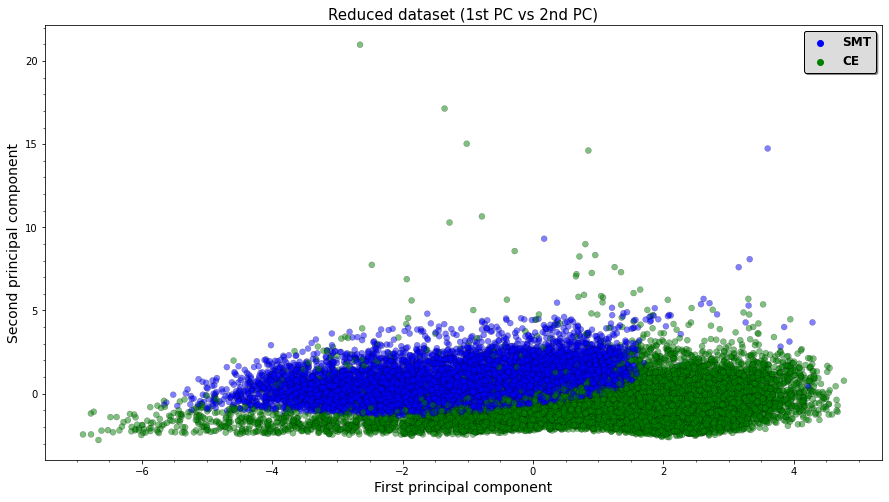

In [8]:
# Data in the PCA basis
data_ = np.dot(V.T, data_PCA)

# Reduce the dimensionality of the dataset 
data_reduced = data_[:ncomp,:] 

X_train_PCA = pd.DataFrame(data_reduced.T)
X_test_PCA = pd.DataFrame(np.dot(V.T, X_test_.T)[:ncomp,:].T)
# print(X_train_PCA.shape)
# print(X_test_PCA.shape)

df = pd.DataFrame(np.column_stack((X_train_PCA, Y_train)))
df.rename(columns = {ncomp:'col.21:CE'}, inplace=True)
display(df.head())

plt.figure(figsize=(15, 8))
sns.scatterplot(x=0, y=1, hue='col.21:CE', data=df, alpha=0.5, palette=['blue', 'green'], edgecolor='black', linewidth=0.3)
plt.xlabel('First principal component', fontsize=14)
plt.ylabel('Second principal component', fontsize=14)
plt.title('Reduced dataset (1st PC vs 2nd PC)', fontsize=15)
plt.minorticks_on()
plt.legend(prop={'weight':'bold','size':12}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
plt.show()

The PCA shows us clearly that there might exist some (combination of) features that allows us to separate the two classes of events. But if, on one hand, this analysis reduces the number of features, on the other hand information about the physical process are lost. So, PCA sped up the training procedure at the cost of less interpretable classification criteria. We will see in the next calculations if PCA is worth to be implemented in the classification task.

### Random Forests

**Random Forests** are an ensemble learning method used for classification, in which multiple decision trees are built during the training and the final output is chosen according to the majority of the predicted labels. The power of this algorithm lies in the variability of the trees in a RF: each tree is trained over a set obtained by randomly sampling with replacement from the original training set. Moreover, each tree can only see a random subset of samples during training (feature randomness). This procedure, called Bootstrap-Aggregation (or bagging for short), reduces the correlation between different trees by adding some randomness to the single tree's classification. However, the average of all the trees does not depend on the noise produced on the training set and thus Random Forests overcome the overfitting issue.

Each decision tree is constructed iteratively by choosing the leaf with the higher **Gini impurity**
$$\sum_{j=CE,SMT} p_j\,(1-p_j)$$
and splitting it into two different leaves according to the feature that leads to the maximum decrease of the Gini impurity. The Gini impurity assumes the maximum value of 0.5 when the labels are distributed 50/50 while it assumes the minimum value of 0 when there is only one label in the leaf.

The **importance of a feature** can be computed from the trained RF: for a single tree it corresponds to the total reduction brought by that feature to the Gini impurity and the feature importances of the RF are computed averaging the single-tree feature importances.

### Random Forest: no smoothing, no normalization of data

In this first attempt to classification we used a reduced training set with only `m_train = 20000` training samples. The data were not normalized and the trees of the RF were allowed to have unlimited depth (in the following notation, a tree is "smooth" if its maximum depth `max_depth` and minimum number of samples in each leaf `min_samples_leaf` are tuned to avoid overfitting). This conditions result in a perfect training procedure (probably overfitting the training data) but also the test seems to be successful. The results obtained in this training are surely a good first guess of the properties of the entire dataset, but we will wait the full training to pick the most important features.

In [9]:
RF_clf = RandomForestClassifier(max_depth=None)
RF_clf.fit(X_train, Y_train)

train_err = 1 - RF_clf.score(X_train, Y_train)
print("Training error = %1.3f" % train_err)
test_err = 1 - RF_clf.score(X_test, Y_test)
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([RF_clf.feature_names_in_, RF_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.000
Test error = 0.006


,feature names,feature importance
9,colExt1:ratio_m1_m2_ZAMS,0.277024
10,colExt2:ratio_m1_m2_rem,0.183373
5,col.7:sma/Rsun,0.126479
2,col.3:m1rem/Msun,0.115411
0,col.1:m1ZAMS/Msun,0.105838
3,col.4:m2rem/Msun,0.055341
6,col.8:ecc,0.051319
1,col.2:m2ZAMS/Msun,0.041976
4,col.6:delay_time/Myr,0.028859
7,metallicity,0.009721


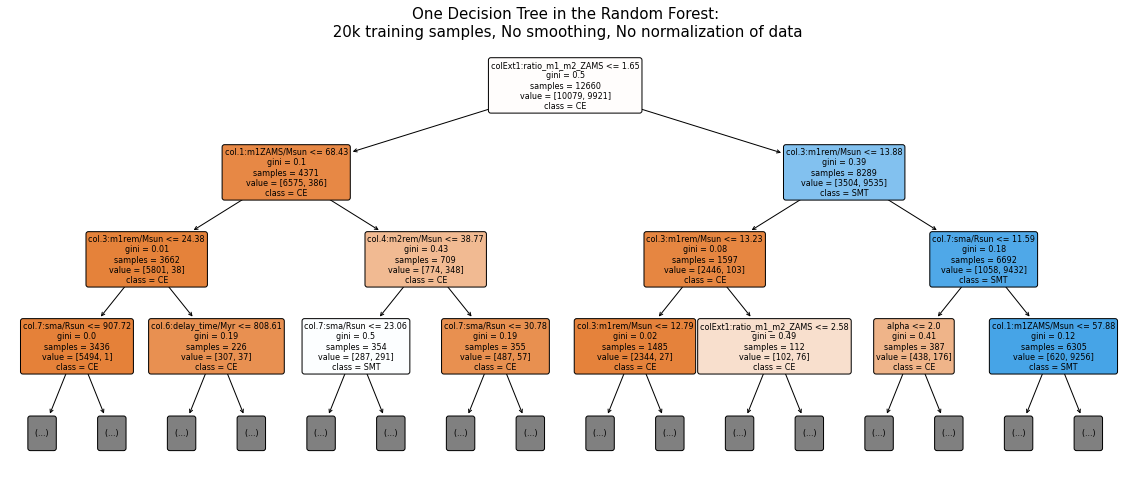

In [70]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(RF_clf.estimators_[50], max_depth=3,
                        feature_names = RF_clf.feature_names_in_,
                        class_names = RF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize = 8, ax = ax)
ax.set_title('One Decision Tree in the Random Forest:\n 20k training samples, No smoothing, No normalization of data',
             fontsize=15)
ax;

The decision tree above has been chosen among the ensemble of 100 trees, and since it contains only a fraction of the RF information it cannot be used to understand the exact decision path followed by the RF. However, even in a single decision tree the most important features show up. Only the first 3 layers of the decision path are shown for clarity, but the tree has reached in some paths an overall depth bigger than 15.

### Random Forest: no smoothing, with normalization of data

In this classification we normalized the input data such that each feature has zero mean and unit variance. This preprocessing is usually helpful in ML algorithms to accelerate and simplify the training procedure, so we implemented it to see if the perfomances of training procedure improve. We also used the reduced training set with `m_train = 20000` training samples and not smooth trees.

In [11]:
normRF_clf = RandomForestClassifier(max_depth=None)
normRF_clf.fit(X_train_, Y_train)

train_err = 1 - normRF_clf.score(X_train_, Y_train)
print("Training error = %1.3f" % train_err)
test_err = 1 - normRF_clf.score(X_test_, Y_test)
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([normRF_clf.feature_names_in_, normRF_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.000
Test error = 0.006


,feature names,feature importance
9,colExt1:ratio_m1_m2_ZAMS,0.262759
10,colExt2:ratio_m1_m2_rem,0.202732
5,col.7:sma/Rsun,0.139002
2,col.3:m1rem/Msun,0.118002
0,col.1:m1ZAMS/Msun,0.106345
3,col.4:m2rem/Msun,0.050162
6,col.8:ecc,0.038528
1,col.2:m2ZAMS/Msun,0.038363
4,col.6:delay_time/Myr,0.028432
7,metallicity,0.010911


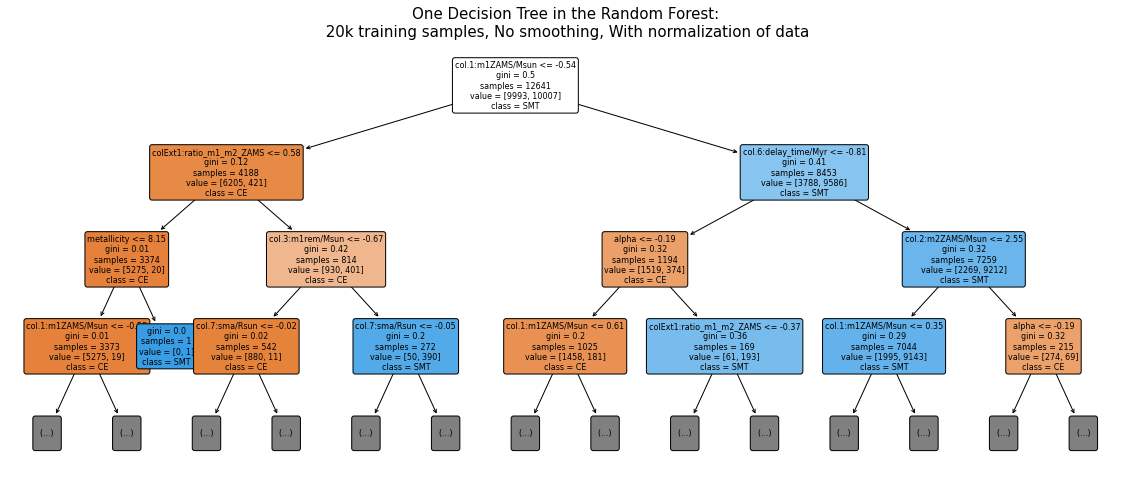

In [69]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(normRF_clf.estimators_[50], max_depth=3,
                        feature_names = normRF_clf.feature_names_in_,
                        class_names = normRF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize = 8, ax = ax)
ax.set_title('One Decision Tree in the Random Forest:\n 20k training samples, No smoothing, With normalization of data',
             fontsize=15)
ax;

The training procedure get similar perfomances with respect to the training with non normalized data, but now the thresholds on the parameters have lost their physical meaning.

### Random Forest: with smoothing, with normalization of data

In this classification we did a cross-validation procedure to find the values of the hyperparameters `max_depth` and `min_samples_leaf` that maximize the score of the training. We **prevent overfitting** by fixing a maximum number of layers the RF can have and by setting a minimum amount of samples each leaf can have (i.e., we "smooth" the trees). With this setting we considerably simplify the model, avoiding the construction of deep trees which have lots of terminal leaves containing only one sample. If with `m_train = 20000` training samples this procedure seems unjustified, that is the only way to obtain a reasonable solution when training over the full dataset.

In [13]:
# cross validation
parameters = {'max_depth':[3,5,7], 'min_samples_leaf':[1e-05,1e-04,1e-03,1e-02]}
cvres = GridSearchCV(RandomForestClassifier(), parameters)
cvres.fit(X_train_, Y_train)

print("Best parameters: ", cvres.best_params_)
display(pd.DataFrame.from_dict(cvres.cv_results_).sort_values(by='rank_test_score', ignore_index=True)[['rank_test_score','mean_test_score','params']].head(3))
smooth_normRF_clf = cvres.best_estimator_

Best parameters:  {'max_depth': 7, 'min_samples_leaf': 0.0001}


,rank_test_score,mean_test_score,params
0,1,0.98120,"{'max_depth': 7, 'min_samples_leaf': 0.0001}"
1,2,0.98060,"{'max_depth': 7, 'min_samples_leaf': 1e-05}"
2,3,0.97845,"{'max_depth': 7, 'min_samples_leaf': 0.001}"


In [14]:
train_err = 1 - smooth_normRF_clf.score(X_train_, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - smooth_normRF_clf.score(X_test_, Y_test)
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([smooth_normRF_clf.feature_names_in_, smooth_normRF_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.016
Test error = 0.016


,feature names,feature importance
9,colExt1:ratio_m1_m2_ZAMS,0.253166
10,colExt2:ratio_m1_m2_rem,0.216567
5,col.7:sma/Rsun,0.132399
2,col.3:m1rem/Msun,0.120995
0,col.1:m1ZAMS/Msun,0.097045
3,col.4:m2rem/Msun,0.056022
1,col.2:m2ZAMS/Msun,0.045206
6,col.8:ecc,0.042976
4,col.6:delay_time/Myr,0.027493
7,metallicity,0.005038


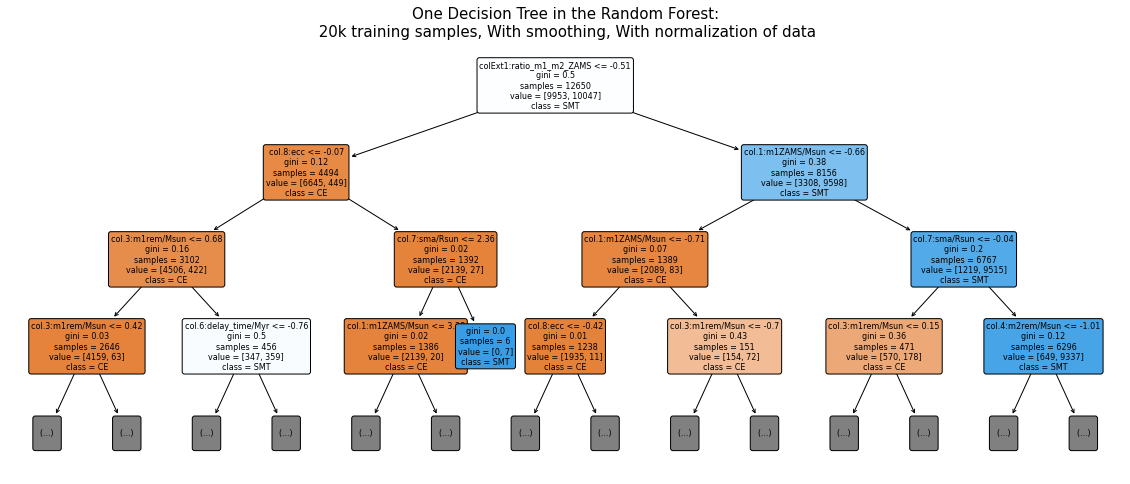

In [68]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(smooth_normRF_clf.estimators_[50], max_depth=3,
                        feature_names = smooth_normRF_clf.feature_names_in_,
                        class_names = smooth_normRF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize = 8, ax = ax)
ax.set_title('One Decision Tree in the Random Forest:\n 20k training samples, With smoothing, With normalization of data',
             fontsize=15)
ax;

As expected, by limiting the trees' maximum depth the test error increases. Among the possible choices, the best parameters found by the validation are `max_depth=7` and `min_samples_leaf=0.0001`. It is interesting to notice that the minimum number of samples per leaf was not chosen to be the minimum that was given (i.e., `min_samples_leaf=1e-05`, corresponding to `ceil(1e-05*m_train)=1` sample), but `min_samples_leaf=1e-04` instead (corresponding to `ceil(1e-04*m_train)=2` samples). This fact means that in the validation procedure the trees with at least 2 samples for each leaf have better generalization properties w.r.t. the trees without this lower bound.

### Random Forest: with smoothing, with PCA

This classification is performed similarly to the previous one, with the exception that the training data are not simply normalized but they are rotated in a new base and reduced in dimensionality via PCA. We still perform a validation on the two hyperparameters and we still train over `m_train = 20000` samples.

In [16]:
# cross validation
parameters = {'max_depth':[3,5,7], 'min_samples_leaf':[1e-05,1e-04,1e-03,1e-02]}
cvres = GridSearchCV(RandomForestClassifier(), parameters)
cvres.fit(X_train_PCA, Y_train)

print("Best parameters: ", cvres.best_params_)
display(pd.DataFrame.from_dict(cvres.cv_results_).sort_values(by='rank_test_score', ignore_index=True)[['rank_test_score','mean_test_score','params']].head(3))
smooth_PCA_RF_clf = cvres.best_estimator_

Best parameters:  {'max_depth': 7, 'min_samples_leaf': 1e-05}


,rank_test_score,mean_test_score,params
0,1,0.97470,"{'max_depth': 7, 'min_samples_leaf': 1e-05}"
1,2,0.97415,"{'max_depth': 7, 'min_samples_leaf': 0.0001}"
2,3,0.97145,"{'max_depth': 7, 'min_samples_leaf': 0.001}"


In [17]:
train_err = 1 - smooth_PCA_RF_clf.score(X_train_PCA, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - smooth_PCA_RF_clf.score(X_test_PCA, Y_test)
print("Test error = %1.3f" % test_err)

Training error = 0.021
Test error = 0.025


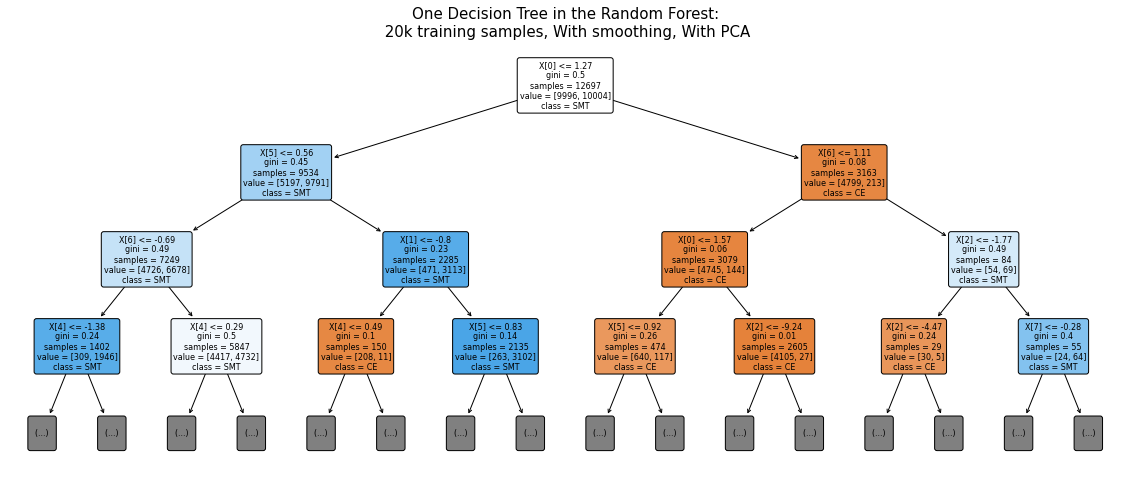

In [67]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(smooth_PCA_RF_clf.estimators_[50], max_depth=3,
                        feature_names = None,
                        class_names = smooth_PCA_RF_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize = 8, ax = ax)
ax.set_title('One Decision Tree in the Random Forest:\n 20k training samples, With smoothing, With PCA',
             fontsize=15)
ax;

By applying PCA we notice that the two errors (train and test errors) increased w.r.t. the training procedure in which data were simply normalized. Moreover, the validation procedure found `min_samples_leaf=1e-05` (corresponding to `ceil(1e-05*m_train)=1` sample) as the optimal minimum number of samples for each leaf, thus the algorithm tends to overfit the data. These results lead us to be skeptic about the effectiveness of the PCA preprocessing applied to the classification with RF algorithms.

### Support Vector Machines (SVM)

**Support Vector Machines** are learning models used for classification in which an hyperplane is used to separate the input space into two different regions (called halfspaces). The hyperplane chosen by the algorithm maximizes the margin (i.e., the distance between the separating hyperplane and the nearest samples of both classes) while trying to reduce as much as possible the number of misclassified samples. For real-world data we must use the soft-margin SVM classification since it can handle also the non-linearly-separable data scenario. Defining $\mathbf{w}$ as the normal vector to the hyperplane (that is not necessairly normalized), the margin is defined as $\tfrac {2}{\|\mathbf {w} \|}$ and the penalty term (also called Hinge loss) associated to a sample $(\mathbf{x}_i,y_i)$, written in homogeneous coordinates, is $l^{hinge}(\mathbf{x}_i,y_i)=\max \left(0,1-y_{i} \left<\mathbf {w},\mathbf{x} _{i}\right> \right)$. The final goal of the optimization is to **minimize**

$$ \lambda \lVert \mathbf{w} \rVert ^{2}+\left[{\frac {1}{n}}\sum _{i=1}^{n}\max \left(0,1-y_{i} \left<\mathbf {w},\mathbf{x} _{i}\right> \right)\right],$$

where $\lambda>0$ controls the trade-off between maximizing the margin width without caring about misclassifications (small $\lambda$) and avoiding misclassifications without caring about the margin width (large $\lambda$).

More detailed information can be found on the [Linear SVM section on Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine#Linear_SVM).

### SVM: with normalization of data

In SVM classification the normalization of data is always a good practice, since it speeds up and it simplifies the training procedure most of the times. Unlike RF, the results of SVM are not easy to be interpreted, so the preprocessing of the data does not influence negatively the interpretability of the model. At first we still used the reduced training set with `m_train = 20000` samples. `LinearSVC` scales better for large samples w.r.t. the analogous `SVC(kernel=’linear’)`. The inverse regularization parameter $C$, defined in terms of $\lambda$ as $C=1/\lambda$, is fixed at the default value of `C=1.0`.

In [19]:
SVM_clf = sklearn.svm.LinearSVC(dual=False)
SVM_clf.fit(X_train_, Y_train)

train_err = 1 - SVM_clf.score(X_train_, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - SVM_clf.score(X_test_, Y_test)
print("Test error = %1.3f" % test_err)

display(pd.DataFrame(data=np.array([SVM_clf.feature_names_in_, np.abs(SVM_clf.coef_[0])]).T,
                     columns=["feature names", "feature weights (absolute value)"]).sort_values(by="feature weights (absolute value)", ascending=False))

Training error = 0.017
Test error = 0.024


,feature names,feature weights (absolute value)
5,col.7:sma/Rsun,7.680087
2,col.3:m1rem/Msun,4.982183
1,col.2:m2ZAMS/Msun,1.937438
10,colExt2:ratio_m1_m2_rem,1.155019
9,colExt1:ratio_m1_m2_ZAMS,1.088686
0,col.1:m1ZAMS/Msun,1.056246
6,col.8:ecc,0.88269
3,col.4:m2rem/Msun,0.532053
7,metallicity,0.19209
4,col.6:delay_time/Myr,0.025827


The results of SVM (with normalization of data) are similar to the results of smooth RF (also with normalization of data) for what concerns training errors and test errors. However, up to now the best performing algorithm is RF without smoothing, but we expect this is caused by the lack of limitations in the growth of the trees in that particular algorithm.

### Full dataset
From now on the full dataset is taken into account in the classification of BBH. The best hyperparameters found by the cross-validation procedure over the limited dataset are used also for the training of the full dataset, because a cross-validation over the full dataset would be computationally demanding.

In [20]:
# fraction of data for test set
test_fract = 0.01
m_test_full = int(frame.shape[0]*test_fract)
m_train_full = frame.shape[0] - m_test_full
frame_sample_full = frame.sample(frac=1, replace=False, ignore_index=True)
frame_train_full = frame_sample_full.iloc[:-m_test_full]
frame_test_full = frame_sample_full.iloc[-m_test_full:]

# separate dataframes
lbl = {False:'SMT', True:'CE'}
X_train_full = frame_train_full.drop(labels=['col.0:ID','col.21:CE'], axis=1)
Y_train_full = frame_train_full["col.21:CE"].apply(lambda x: lbl[x])
X_test_full = frame_test_full.drop(labels=['col.0:ID','col.21:CE'], axis=1)
Y_test_full = frame_test_full["col.21:CE"].apply(lambda x: lbl[x])

### PCA on the full dataset

In [21]:
# DATA NORMALIZATION
# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_train_full)

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
pd.set_option("chop_threshold", 1e-08)

X_train_full_ = pd.DataFrame(scaler.transform(X_train_full),columns=X_train_full.columns)
df_tmp = pd.DataFrame(np.around(pd.concat([X_train_.mean(axis=0), X_train_.std(axis=0)], axis=1), 3))
df_tmp.columns = ['mean','std']
print ("\nMean and std of the training input data:")
display(df_tmp)

X_test_full_ = pd.DataFrame(scaler.transform(X_test_full),columns=X_test_full.columns) # use the same transformation on test data
# df_tmp = pd.DataFrame(np.around(pd.concat([X_test_.mean(axis=0), X_test_.std(axis=0)], axis=1), 3))
# df_tmp.columns = ['mean','std']
# print ("\nMean and std of the test input data:")
# display(df_tmp)

# PCA
data_PCA = X_train_full_.cov()

# eigenvectors and eigenvalues using covariance matrix
l, V = la.eig(data_PCA)

# sort to have the eigenvalues in descending order
idx = l.argsort()[::-1]
l = np.real_if_close(l[idx])
V = V[:, idx]

np.set_printoptions(precision=3)
print('\nEigenvalues: \n', l)
#print('Eigenvectors:\n', V)

ncomp = 8
variability_PC = np.sum(l[:ncomp])/np.sum(l)
print('\nPercent of the total variability explained by the %.0f principal components: %.5f' %(ncomp, variability_PC))


Mean and std of the training input data:


,mean,std
col.1:m1ZAMS/Msun,0.0,1.0
col.2:m2ZAMS/Msun,0.0,1.0
col.3:m1rem/Msun,0.0,1.0
col.4:m2rem/Msun,0.0,1.0
col.6:delay_time/Myr,0.0,1.0
col.7:sma/Rsun,0.0,1.0
col.8:ecc,0.0,1.0
metallicity,0.0,1.0
alpha,0.0,1.0
colExt1:ratio_m1_m2_ZAMS,0.0,1.0



Eigenvalues: 
 [4.059 1.712 1.329 1.005 0.94  0.871 0.514 0.452 0.069 0.039 0.011]

Percent of the total variability explained by the 8 principal components: 0.98917


(2419281, 8)
(24437, 8)


,0,1,2,3,4,5,6,7,col.21:CE
0,0.140689,-0.409915,-0.220183,-0.259179,-1.510194,-0.033487,-1.061207,-0.583348,CE
1,-0.086911,-1.952564,1.283315,0.077196,-1.513186,0.743892,-0.829352,-1.811886,SMT
2,2.295534,-0.767765,0.49435,0.018762,-0.631755,0.226581,-0.125828,-0.301834,CE
3,1.527138,0.404614,-1.043015,0.105723,0.447827,0.317964,-0.438262,-0.984717,CE
4,-0.613002,-1.191224,0.046702,0.479193,0.885922,1.111918,-0.133516,-0.933728,SMT


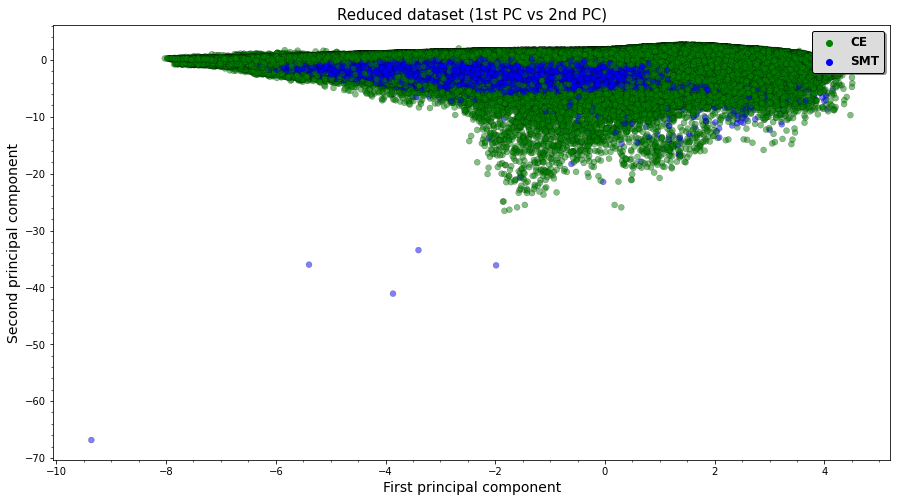

In [22]:
# Data in the PCA basis
data_ = np.dot(X_train_full_, V)

# Reduce the dimensionality of the dataset 
data_reduced = data_[:,:ncomp]

X_train_PCA_full = pd.DataFrame(data_reduced)
X_test_PCA_full = pd.DataFrame(np.dot(X_test_full_, V)[:,:ncomp])
print(X_train_PCA_full.shape)
print(X_test_PCA_full.shape)

df = pd.DataFrame(np.column_stack((X_train_PCA_full, Y_train_full)))
df.rename(columns = {ncomp:'col.21:CE'}, inplace=True)
display(df.head())

plt.figure(figsize=(15, 8))
sns.scatterplot(x=0, y=1, hue='col.21:CE', data=df, alpha=0.5, palette=['green', 'blue'], edgecolor='black', linewidth=0.3)
plt.xlabel('First principal component', fontsize=14)
plt.ylabel('Second principal component', fontsize=14)
plt.title('Reduced dataset (1st PC vs 2nd PC)', fontsize=15)
plt.legend(prop={'weight':'bold','size':12}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
plt.minorticks_on()
plt.show()

### Random Forest: Full dataset with smoothing, no normalization of data

Even if in this training we use smooth trees (with `max_depth=7` and `min_samples_leaf'=1e-04`), the RF algorithm finds successfully a good model, with errors less than 1%. We can conclude that it is not necessary to use deep and sample-specific trees to perform this classification, since also simpler trees are able to perfom a good classification.

In [23]:
best_param = {'max_depth':7, 'min_samples_leaf':1e-04}
smooth_RF_full_clf = RandomForestClassifier(max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf'])
smooth_RF_full_clf.fit(X_train_full, Y_train_full)

train_err = 1 - smooth_RF_full_clf.score(X_train_full, Y_train_full)
print("Training error = %1.5f" % train_err)

test_err = 1 - smooth_RF_full_clf.score(X_test_full, Y_test_full)
print("Test error = %1.5f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([smooth_RF_full_clf.feature_names_in_, smooth_RF_full_clf.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.00974
Test error = 0.01121


,feature names,feature importance
9,colExt1:ratio_m1_m2_ZAMS,0.288824
10,colExt2:ratio_m1_m2_rem,0.13535
5,col.7:sma/Rsun,0.134266
2,col.3:m1rem/Msun,0.110885
0,col.1:m1ZAMS/Msun,0.104771
1,col.2:m2ZAMS/Msun,0.067948
3,col.4:m2rem/Msun,0.063036
6,col.8:ecc,0.039646
4,col.6:delay_time/Myr,0.03128
8,alpha,0.012198


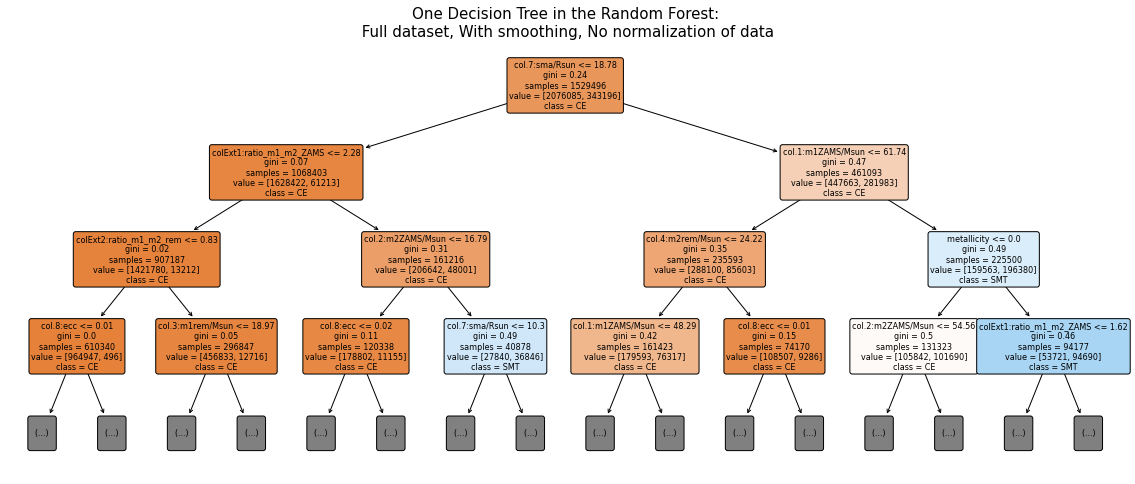

In [24]:
# first 3 layers of tree
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sklearn.tree.plot_tree(smooth_RF_full_clf.estimators_[50], max_depth=3,
                        feature_names = smooth_RF_full_clf.feature_names_in_,
                        class_names = smooth_RF_full_clf.classes_,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True,
                        fontsize = 8, ax = ax)
ax.set_title('One Decision Tree in the Random Forest:\n Full dataset, With smoothing, No normalization of data',
             fontsize=15)
ax;

### Random Forest: Full dataset with smoothing, with PCA

The training of smooth trees over the full dataset, that has been reduced in dimensionality via PCA, is not as successful as the training over the original non-normalized data. Even if the errors are not bigger than SVM's errors (see next blocks of code), the existence of a better solution using RF without preprocessing the data (either normalization or PCA) let us conclude that the original data are already self-explicative.

In [25]:
best_param = {'max_depth':7, 'min_samples_leaf':1e-04}
smooth_RF_PCA_full_clf = RandomForestClassifier(max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf'])
smooth_RF_PCA_full_clf.fit(X_train_PCA_full, Y_train_full)

train_err = 1 - smooth_RF_PCA_full_clf.score(X_train_PCA_full, Y_train_full)
print("Training error = %1.3f" % train_err)

test_err = 1 - smooth_RF_PCA_full_clf.score(X_test_PCA_full, Y_test_full)
print("Test error = %1.3f" % test_err)

Training error = 0.021
Test error = 0.023


### SVM: full dataset, with normalization of data

In [26]:
SVM_full_clf = sklearn.svm.LinearSVC(dual=False)
SVM_full_clf.fit(X_train_full_, Y_train_full)

train_err = 1 - SVM_full_clf.score(X_train_full_, Y_train_full)
print("Training error = %1.3f" % train_err)

test_err = 1 - SVM_full_clf.score(X_test_full_, Y_test_full)
print("Test error = %1.3f" % test_err)

display(pd.DataFrame(data=np.array([SVM_full_clf.feature_names_in_, np.abs(SVM_full_clf.coef_[0])]).T,
                     columns=["feature names", "feature weights (absolute value)"]).sort_values(by="feature weights (absolute value)", ascending=False))

Training error = 0.022
Test error = 0.021


,feature names,feature weights (absolute value)
2,col.3:m1rem/Msun,5.4203
1,col.2:m2ZAMS/Msun,2.448793
10,colExt2:ratio_m1_m2_rem,1.607454
0,col.1:m1ZAMS/Msun,1.33237
9,colExt1:ratio_m1_m2_ZAMS,0.799539
3,col.4:m2rem/Msun,0.668686
5,col.7:sma/Rsun,0.354497
7,metallicity,0.336735
6,col.8:ecc,0.197005
4,col.6:delay_time/Myr,0.132663


### SVM: full dataset, with PCA

Also within SVM classification it is possible to notice that the PCA dimensionality-reduction decreases the performances of the learning algorithm.

In [27]:
SVM_PCA_full_clf = sklearn.svm.LinearSVC(dual=False)
SVM_PCA_full_clf.fit(X_train_PCA_full, Y_train_full)

train_err = 1 - SVM_PCA_full_clf.score(X_train_PCA_full, Y_train_full)
print("Training error = %1.3f" % train_err)

test_err = 1 - SVM_PCA_full_clf.score(X_test_PCA_full, Y_test_full)
print("Test error = %1.3f" % test_err)

Training error = 0.034
Test error = 0.036


## Graphs
### Initial and final masses of the members

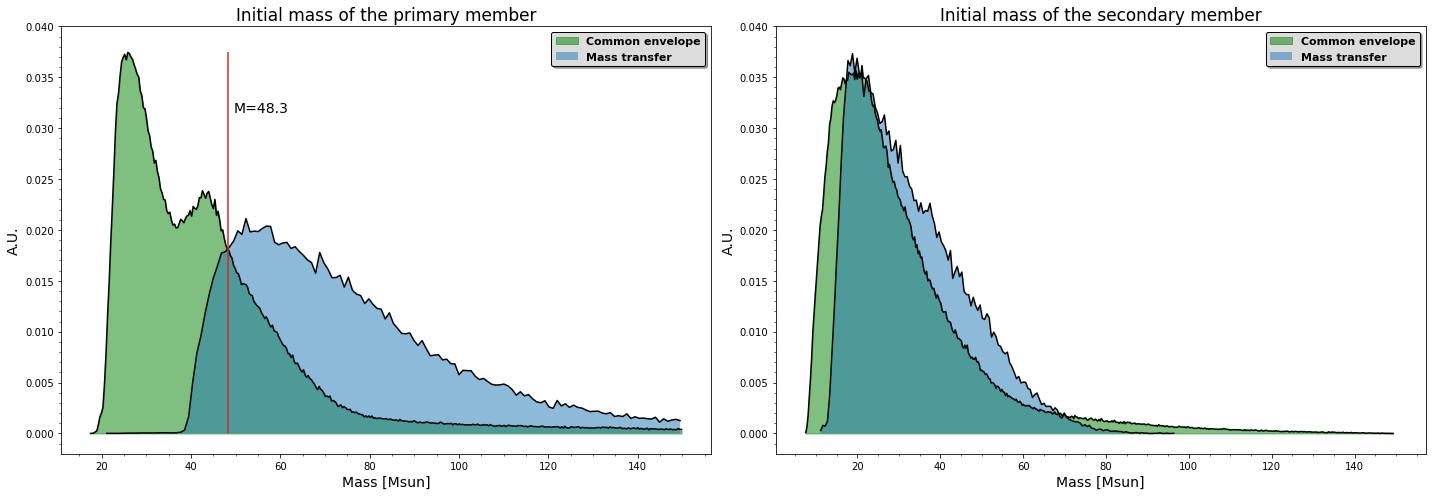

In [53]:
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(20, 7))



#[0]  -   col.1:m1ZAMS/Msun - col.21:CE   - Initial mass of the primary member per Formation Process

entries_1_t, edges_1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.1:m1ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_1_t = 0.5 * (edges_1_t[:-1] + edges_1_t[1:])       #Norm Hist for TRUE - CommonEnvelope  

entries_1_f, edges_1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.1:m1ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_1_f = 0.5 * (edges_1_f[:-1] + edges_1_f[1:])       #Norm Hist for FALSE - StableMassTransfer

ax[0].plot(bin_centers_1_t, entries_1_t, color='black')
ax[0].fill_between(bin_centers_1_t, entries_1_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0].plot(bin_centers_1_f, entries_1_f, color='black')
ax[0].fill_between(bin_centers_1_f, entries_1_f, alpha=0.5, label = 'Mass transfer')

# find vertical red line
for i in range(len(bin_centers_1_f)):
    idx = (np.abs(bin_centers_1_t - bin_centers_1_f[i])).argmin()
    if entries_1_t[idx] <= entries_1_f[i]: 
        eq_pos = (bin_centers_1_t[idx-1]+bin_centers_1_t[idx])/2
        break
ax[0].vlines(eq_pos, ymin=0, ymax=0.0375, color='C3')
ax[0].text(eq_pos+1.2, 0.032, s = 'M='+str(round(eq_pos, 1)),
           horizontalalignment = 'left', verticalalignment='center', fontsize=14)

ax[0].set_title('Initial mass of the primary member', fontsize=17)
ax[0].set_ylim(-0.002, 0.04)



#[1]  -   col.2:m2ZAMS/Msun - col.21:CE   - Initial mass of the secondary member per Formation Process

entries_2_t, edges_2_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.2:m2ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_2_t = 0.5 * (edges_2_t[:-1] + edges_2_t[1:])      # Norm Hist for TRUE - CommonEnvelope 

entries_2_f, edges_2_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.2:m2ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_2_f = 0.5 * (edges_2_f[:-1] + edges_2_f[1:])      #Norm Hist for FALSE - StableMassTransfer

ax[1].plot(bin_centers_2_t, entries_2_t, color='black')
ax[1].fill_between(bin_centers_2_t, entries_2_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1].plot(bin_centers_2_f, entries_2_f, color='black')
ax[1].fill_between(bin_centers_2_f, entries_2_f, alpha=0.5, label = 'Mass transfer')

ax[1].set_title('Initial mass of the secondary member', fontsize=17)
ax[1].set_ylim(-0.002, 0.04)


#legend & titles
for x in ax:
    x.minorticks_on()
    x.set_ylabel('A.U.', fontsize=14) 
    x.set_xlabel('Mass [Msun]', fontsize=14)
    x.legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)


fig.tight_layout()

- In the left plot the two formation processes are characterized by two different ranges of mass values: increasing the initial mass of the primary member the Stable Mass Transfer process is predominant with respect to the CE. In particular, the separation occurs at $M=48.3 M_{Sun}$.

- In contrast, concerning the initial mass of the secondary member (right plot) there are no regions of mass values related to a predominance of one of the two formation processes. 

These plots support the results obtained by the Random Forest algorithm, which show how in the classification task the initial mass of the primary member is much more relevant than the mass of the secondary member.


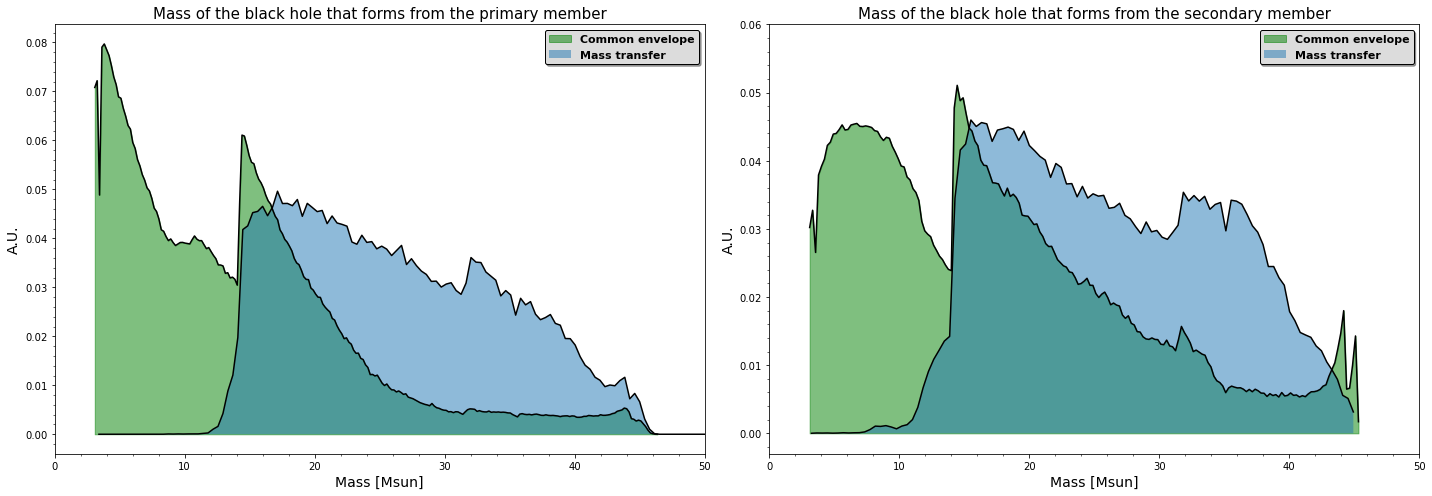

In [54]:
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(20, 7))



#[0]  -   col.3:m1rem/Msun - col.21:CE   - BlackHole mass from the primary member per Formation Process

entries_3_t, edges_3_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.3:m1rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_3_t = 0.5 * (edges_3_t[:-1] + edges_3_t[1:])    #Norm Hist for TRUE - CommonEnvelope

entries_3_f, edges_3_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.3:m1rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_3_f = 0.5 * (edges_3_f[:-1] + edges_3_f[1:])    #Norm Hist for FALSE - StableMassTransfer

ax[0].plot(bin_centers_3_t, entries_3_t, color='black')
ax[0].fill_between(bin_centers_3_t, entries_3_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0].plot(bin_centers_3_f, entries_3_f, color='black')
ax[0].fill_between(bin_centers_3_f, entries_3_f, alpha=0.5, label = 'Mass transfer')

ax[0].set_xlim(right=50, left= 0)
ax[0].set_title('Mass of the black hole that forms from the primary member', fontsize=15)



#[1]  -   col.4:m2rem/Msun - col.21:CE   - BlackHole mass from the secondary member per Formation Process

entries_4_t, edges_4_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.4:m2rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_4_t = 0.5 * (edges_4_t[:-1] + edges_4_t[1:])          #Norm Hist for TRUE - CommonEnvelope

entries_4_f, edges_4_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.4:m2rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_4_f = 0.5 * (edges_4_f[:-1] + edges_4_f[1:])          #Norm Hist for FALSE - StableMassTransfer

ax[1].plot(bin_centers_4_t, entries_4_t, color='black')
ax[1].fill_between(bin_centers_4_t, entries_4_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1].plot(bin_centers_4_f, entries_4_f, color='black')
ax[1].fill_between(bin_centers_4_f, entries_4_f, alpha=0.5, label = 'Mass transfer')

ax[1].set_xlim(right=50, left=0)
ax[1].set_ylim(bottom=-0.003, top=0.06)
ax[1].set_title('Mass of the black hole that forms from the secondary member', fontsize=15)


#legend & titles
for x in ax:
    x.minorticks_on()
    x.set_ylabel('A.U.', fontsize=14)  
    x.set_xlabel('Mass [Msun]', fontsize=14)
    x.legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)

    
fig.tight_layout()

These two graphs show a similar behaviour regarding the formation processes and the mass of the black hole originated by the primary (on the left) and the secondary (on the right) members. 

For both observables in fact there are not specific regions of values carachterized by a clear separation within one of the two formation processes. 


### Time elapsed, eccentricity, sma

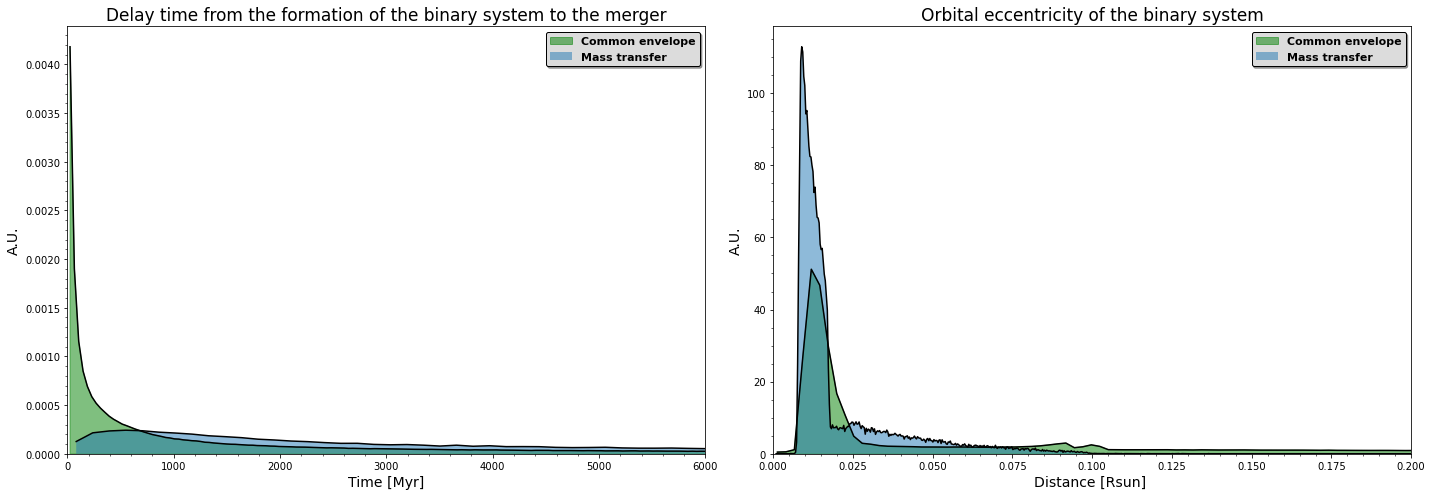

In [30]:
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(20, 7))



#[0]  -   col.6:delay_time/Myr - col.21:CE   - Delay Time per Formation Process

entries_1_t, edges_1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.6:delay_time/Myr'], bins = 'fd', color = 'w', density=True)
bin_centers_1_t = 0.5 * (edges_1_t[:-1] + edges_1_t[1:])

entries_1_f, edges_1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.6:delay_time/Myr'], bins = 'fd', color = 'w', density=True)
bin_centers_1_f = 0.5 * (edges_1_f[:-1] + edges_1_f[1:])

ax[0].plot(bin_centers_1_t, entries_1_t, color='black')
ax[0].fill_between(bin_centers_1_t, entries_1_t, alpha=0.5, color='green', label = 'Common envelope')
ax[0].plot(bin_centers_1_f, entries_1_f, color='black')
ax[0].fill_between(bin_centers_1_f, entries_1_f, alpha=0.5, label = 'Mass transfer')
ax[0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0].set_title('Delay time from the formation of the binary system to the merger', fontsize=17)
ax[0].set_xlabel('Time [Myr]', fontsize=14)
ax[0].set_ylabel('A.U.', fontsize=14)
ax[0].set_xlim(left=-0.5, right=6000)
ax[0].set_ylim(bottom=0)
ax[0].minorticks_on()



#[1]  -   col.8:ecc - col.21:CE   - Orbital eccentricity of the binary system vs Formation Process

entries_1_t, edges_1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.8:ecc'], bins = 'fd', color = 'w', density=True)
bin_centers_1_t = 0.5 * (edges_1_t[:-1] + edges_1_t[1:])

entries_1_f, edges_1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.8:ecc'], bins = 'fd', color = 'w', density=True)
bin_centers_1_f = 0.5 * (edges_1_f[:-1] + edges_1_f[1:])

ax[1].plot(bin_centers_1_t, entries_1_t, color='black')
ax[1].fill_between(bin_centers_1_t, entries_1_t, alpha=0.5, color='green', label = 'Common envelope')
ax[1].plot(bin_centers_1_f, entries_1_f, color='black')
ax[1].fill_between(bin_centers_1_f, entries_1_f, alpha=0.5, label = 'Mass transfer')
ax[1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1].set_title('Orbital eccentricity of the binary system', fontsize=17)
ax[1].set_xlabel('Distance [Rsun] ', fontsize=14)
ax[1].set_ylabel('A.U.', fontsize=14)
ax[1].set_xlim(left=0, right=0.2)
ax[1].set_ylim(bottom=0)
ax[1].minorticks_on()#legend & titles


fig.tight_layout()

- The first plot shows the relation between the formation process and the time elapsed from the formation of the bynary system to the merger of the two black holes: for most of values of this parameter there is a similar correlation with the two formation processes.
 
  As in the Random Forest results, this feature has  almost no impact in the binary black hole evolution. 
  
<br />

- The second plot represents the relation between the orbital eccentricity of the binary system and the formation process. For all the measured values of this parameter there is not a predominance for one process over the other.

  In agreement with the results of the machine learning algorithm this feature is not useful to our classification task.  


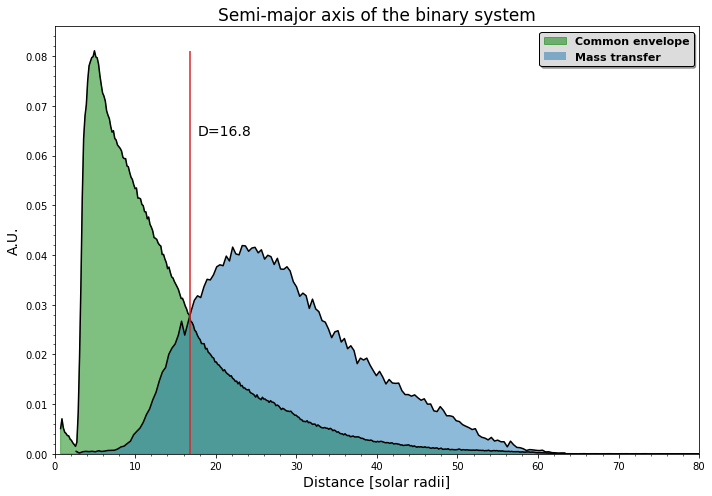

In [59]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(10, 7))

entries_1_t, edges_1_t, _ = plt.hist(frame[(frame['col.21:CE']==True) & (frame['col.7:sma/Rsun']<150)]['col.7:sma/Rsun'], bins = 'fd', color = 'w', density=True)
bin_centers_1_t = 0.5 * (edges_1_t[:-1] + edges_1_t[1:])

entries_1_f, edges_1_f, _ = plt.hist(frame[(frame['col.21:CE']==False) & (frame['col.7:sma/Rsun']<150)]['col.7:sma/Rsun'], bins = 'fd', color = 'w', density=True)
bin_centers_1_f = 0.5 * (edges_1_f[:-1] + edges_1_f[1:])

ax.plot(bin_centers_1_t, entries_1_t, color='black')
ax.fill_between(bin_centers_1_t, entries_1_t, alpha=0.5, color='green', label = 'Common envelope')

ax.plot(bin_centers_1_f, entries_1_f, color='black')
ax.fill_between(bin_centers_1_f, entries_1_f, alpha=0.5, label = 'Mass transfer')

# find vertical red line
for i in range(len(bin_centers_1_f)):
    idx = (np.abs(bin_centers_1_t - bin_centers_1_f[i])).argmin()
    if entries_1_t[idx] <= entries_1_f[i]: 
        eq_pos = (bin_centers_1_t[idx -1]+bin_centers_1_t[idx])/2
        break
ax.vlines(eq_pos, ymin=0, ymax=0.081, color='C3')
ax.text(eq_pos+1, 0.065, s = 'D='+str(round(eq_pos, 1)),    #check eq_pos
           horizontalalignment = 'left', verticalalignment='center', fontsize=14)


#legend & titles
ax.legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax.set_title('Semi-major axis of the binary system', fontsize=17)
ax.set_xlabel('Distance [solar radii]', fontsize=14)
ax.set_ylabel('A.U.', fontsize=14)
ax.set_xlim(left=0, right=80)
ax.set_ylim(bottom=0, top=0.086)
ax.minorticks_on()


fig.tight_layout()

From this plot we can see that the semi-major axis of the binary system at the formation of the second-born black hole is different between the two formation processes also with an almost clear separation between the two cases. Indeed, the value of this parameter is smaller when the system undergoes a Common Envelope with respect to when it evolves via Stable Mass Transfer.

We believe that this difference is related to the Common Envelope process, during which the two members of the binary system reduce their mutual distance by spiraling in the gaseous environment. 
As an effect of the spiral in, after the CE we expect an orbital separation of the two objects much smaller than the initial one.

This separation is also useful for the Random Forest algorithm, in the sense that is a good discriminant for splitting and analyzing the data.

### Mass ratio

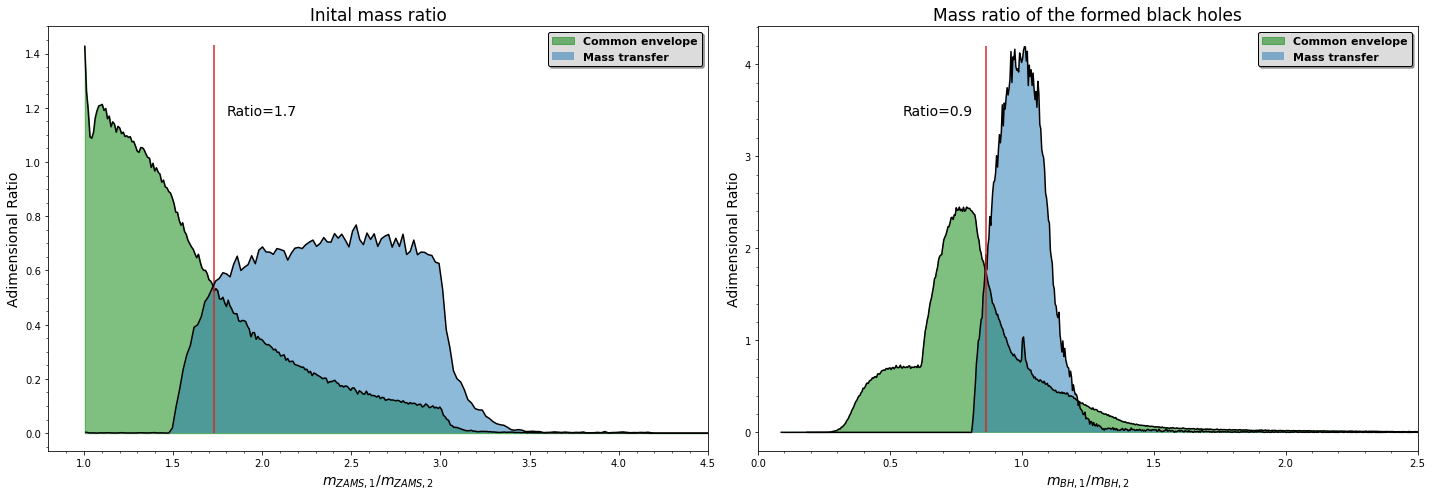

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))



#[0]  -   col.1:m1ZAMS/Msun - col.21:CE   - Initial mass of the primary member per Formation Process

entries_ex1_t, edges_ex1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['colExt1:ratio_m1_m2_ZAMS'], bins = 'fd', color = 'w', density=True)
bin_centers_ex1_t = 0.5 * (edges_ex1_t[:-1] + edges_ex1_t[1:])       #Norm Hist for TRUE - CommonEnvelope  

entries_ex1_f, edges_ex1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['colExt1:ratio_m1_m2_ZAMS'], bins = 'fd', color = 'w', density=True)
bin_centers_ex1_f = 0.5 * (edges_ex1_f[:-1] + edges_ex1_f[1:])       #Norm Hist for FALSE - StableMassTransfer

ax[0].plot(bin_centers_ex1_t, entries_ex1_t, color='black')
ax[0].fill_between(bin_centers_ex1_t, entries_ex1_t, alpha=0.5, color='green', label = 'Common envelope')

# find vertical red line
for i in range(len(bin_centers_ex1_f)):
    idx = (np.abs(bin_centers_ex1_t - bin_centers_ex1_f[i])).argmin()
    if entries_ex1_t[idx] <= entries_ex1_f[i]: 
        eq_pos_ex1 = bin_centers_ex1_t[idx-1]
        break
ax[0].vlines(eq_pos_ex1, ymin=0, ymax=1.43, color='C3')
ax[0].text(0.27, 0.8, s = 'Ratio='+str(round(eq_pos_ex1, 1)),
           horizontalalignment = 'left', verticalalignment='center', transform=ax[0].transAxes, fontsize=14)


ax[0].plot(bin_centers_ex1_f, entries_ex1_f, color='black')
ax[0].fill_between(bin_centers_ex1_f, entries_ex1_f, alpha=0.5, label = 'Mass transfer')
ax[0].set_title('Inital mass ratio', fontsize=17)
ax[0].set_xlabel(r'$m_{ZAMS, 1}/m_{ZAMS, 2}$', fontsize=14)
ax[0].set_xlim(left=0.8,right=4.5)
ax[0].set_ylim(bottom=-0.065,top=1.5)



#[1]  -   col.2:m2ZAMS/Msun - col.21:CE   - Initial mass of the secondary member per Formation Process

entries_ex2_t, edges_ex2_t, _ = plt.hist(frame[frame['col.21:CE']==True]['colExt2:ratio_m1_m2_rem'], bins = 'fd', color = 'w', density=True)
bin_centers_ex2_t = 0.5 * (edges_ex2_t[:-1] + edges_ex2_t[1:])      # Norm Hist for TRUE - CommonEnvelope 

entries_ex2_f, edges_ex2_f, _ = plt.hist(frame[frame['col.21:CE']==False]['colExt2:ratio_m1_m2_rem'], bins = 'fd', color = 'w', density=True)
bin_centers_ex2_f = 0.5 * (edges_ex2_f[:-1] + edges_ex2_f[1:])      #Norm Hist for FALSE - StableMassTransfer

ax[1].plot(bin_centers_ex2_t, entries_ex2_t, color='black')
ax[1].fill_between(bin_centers_ex2_t, entries_ex2_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1].plot(bin_centers_ex2_f, entries_ex2_f, color='black')
ax[1].fill_between(bin_centers_ex2_f, entries_ex2_f, alpha=0.5, label = 'Mass transfer')

# find vertical red line
for i in range(100 , len(bin_centers_ex2_f)):
    idx = (np.abs(bin_centers_ex2_t - bin_centers_ex2_f[i])).argmin()
    if entries_ex2_t[idx] <= entries_ex2_f[i]: 
        eq_pos_ex2 = (bin_centers_ex2_t[idx-1]+bin_centers_ex2_t[idx])/2
        break
ax[1].vlines(eq_pos_ex2, ymin=0, ymax=4.2, color='C3')
ax[1].text(0.22, 0.8, s = 'Ratio='+str(round(eq_pos_ex2, 1)), #check eq_pos
           horizontalalignment = 'left', verticalalignment='center', transform=ax[1].transAxes, fontsize=14)


ax[1].set_title('Mass ratio of the formed black holes', fontsize=17)
ax[1].set_xlabel(r'$m_{BH, 1}/m_{BH, 2}$', fontsize=14)
ax[1].set_xlim(left=0,right=2.5)
ax[1].set_ylim(bottom=-0.2)


#legend & titles
for x in ax:
    x.minorticks_on()
    x.set_ylabel('Adimensional Ratio', fontsize=14)
    x.legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)

    
fig.tight_layout()

The mass ratio of the two bodies, both at the ZAMS and at the end, after the formation of the BHs, represent the most relevant feature for the Random Forest algorithm used to classify the data according to the BBH formation process. The two graphs represent:
- On the left: the ratio between the initial masses of the primary and the secondary member. Clearly this ratio is bigger than 1 because in the formation of a BBH $ \  \ m_{ZAMS, 1}\  \ > m_{ZAMS, 2} \ \ $, this feature of the data is crearly seen in the graph below as we see that the plotted data never overcome the $y=x$ line.
- On the right: the ratio between the mass of the Black Hole that originates from the primary member and the one that forms from the secondary member. This ratio, due to the mass transfer happening during the two processes, can be smaller than one as we con observe in the graph below where, in the scatter plot representing the masses of the two black holes the data are not kept under the line $y=x$.

In both plots there is a similar behaviour: there are regions of mass ratios related to a predominance of one formation process over the other.
In fact, especially in the left plot, for an increasing value of the ratio between the two initial masses, the "absolute preference" for the Common Envelope process decreases in favor of the Stable mass transfer.


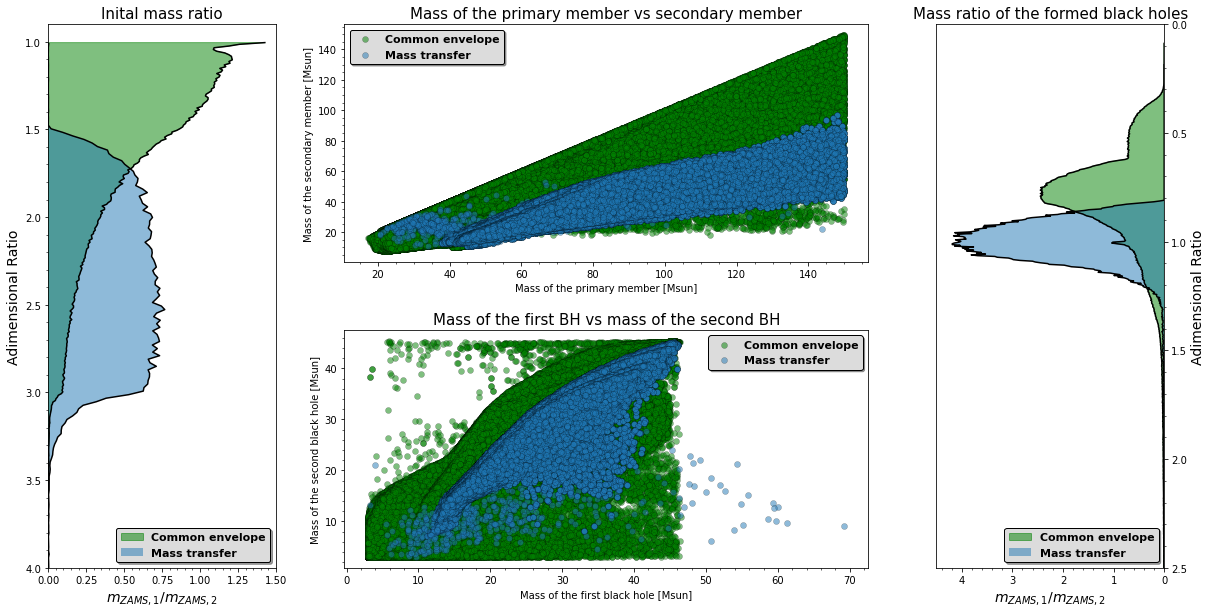

In [66]:
# Visualizing the masses
plt.figure(figsize = (20, 10))
grid = plt.GridSpec(4, 4, wspace =0.3, hspace = 0.8)

g1 = plt.subplot(grid[:, 0])
g2 = plt.subplot(grid[:2, 1:3])
g3 = plt.subplot(grid[2:, 1:3])
g4 = plt.subplot(grid[:, 3])



#g1  -   col.21:CE - colExt1:ratio_m1_m2_ZAMS  - Initial mass ratio per Formation Process 

entries_g1_t, edges_g1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['colExt1:ratio_m1_m2_ZAMS'], bins = 'fd', color = 'w', density=True)
bin_centers_g1_t = 0.5 * (edges_g1_t[:-1] + edges_g1_t[1:])       #Norm Hist for TRUE - CommonEnvelope  
entries_g1_f, edges_g1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['colExt1:ratio_m1_m2_ZAMS'], bins = 'fd', color = 'w', density=True)
bin_centers_g1_f = 0.5 * (edges_g1_f[:-1] + edges_g1_f[1:])       #Norm Hist for FALSE - StableMassTransfer

g1.plot(entries_g1_t, bin_centers_g1_t,   color='black')
g1.fill_betweenx(bin_centers_g1_t, entries_g1_t, x2=0, color='green', alpha=0.5, label = 'Common envelope')

g1.plot(entries_g1_f, bin_centers_g1_f,   color='black')
g1.fill_betweenx(bin_centers_g1_f, entries_g1_f, x2=0, alpha=0.5, label = 'Mass transfer')

g1.legend(prop={'weight':'bold','size':11}, loc='lower right', facecolor='gainsboro', edgecolor='black', shadow=True)
g1.set_title('Inital mass ratio', fontsize=15)
g1.set_xlabel(r'$m_{ZAMS, 1}/m_{ZAMS, 2}$', fontsize=14)
g1.set_ylabel('Adimensional Ratio', fontsize=14)                 #legend & titles
g1.set_ylim(top = 4, bottom = 0.9)
g1.set_xlim(left = 0, right = 1.5)
g1.invert_yaxis()
g1.minorticks_on()



#g4  -   col.21:CE - colExt1:ratio_m1_m2_ZAMS  - Mass ratio of the formed BHs per Formation Process 

entries_g4_t, edges_g4_t, _ = plt.hist(frame[frame['col.21:CE']==True]['colExt2:ratio_m1_m2_rem'], bins = 'fd', color = 'w', density=True)
bin_centers_g4_t = 0.5 * (edges_g4_t[:-1] + edges_g4_t[1:])       #Norm Hist for TRUE - CommonEnvelope

entries_g4_f, edges_g4_f, _ = plt.hist(frame[frame['col.21:CE']==False]['colExt2:ratio_m1_m2_rem'], bins = 'fd', color = 'w', density=True)
bin_centers_g4_f = 0.5 * (edges_g4_f[:-1] + edges_g4_f[1:])       #Norm Hist for FALSE - StableMassTransfer

g4.plot(entries_g4_t, bin_centers_g4_t,   color='black')
g4.fill_betweenx(bin_centers_g4_t, entries_g4_t, x2=0, color='green', alpha=0.5, label = 'Common envelope')

g4.plot(entries_g4_f, bin_centers_g4_f,   color='black')
g4.fill_betweenx(bin_centers_g4_f, entries_g4_f, x2=0, alpha=0.5, label = 'Mass transfer')

g4.legend(prop={'weight':'bold','size':11}, loc='lower right', facecolor='gainsboro', edgecolor='black', shadow=True)
g4.set_title('Mass ratio of the formed black holes', fontsize=15)
g4.set_xlabel(r'$m_{ZAMS, 1}/m_{ZAMS, 2}$', fontsize=14)
g4.set_ylabel('Adimensional Ratio', fontsize=14)                 #legend & titles
g4.invert_yaxis()
g4.set_ylim(top = 0, bottom=2.5)
g4.set_xlim(left = 0, right=4.5)
g4.invert_xaxis()
g4.yaxis.tick_right()
g4.yaxis.set_label_position("right")
g4.minorticks_on()



#g2  -   col.1:m1ZAMS/Msun - col.2:m2ZAMS/Msun  - Mass of the primary member vs secondary member

g2.scatter(x=frame[frame['col.21:CE']==True]['col.1:m1ZAMS/Msun'], y=frame[frame['col.21:CE']==True]['col.2:m2ZAMS/Msun'], alpha=0.5, edgecolor='black', color='green', linewidth=0.3, label='Common envelope')
g2.scatter(x=frame[frame['col.21:CE']==False]['col.1:m1ZAMS/Msun'], y=frame[frame['col.21:CE']==False]['col.2:m2ZAMS/Msun'], alpha=0.5, edgecolor='black', linewidth=0.3, label='Mass transfer')

g2.set_xlabel('Mass of the primary member [Msun]')
g2.set_ylabel('Mass of the secondary member [Msun]')
g2.legend(prop={'weight':'bold','size':11}, loc='best', facecolor='gainsboro', edgecolor='black', shadow=True)
g2.set_title('Mass of the primary member vs secondary member', fontsize=15)
g2.minorticks_on()



#g3  -   col.3:m1rem/Msun - col.4:m2rem/Msun  - Mass of the first BH vs mass of the second BH

g3.scatter(x=frame[frame['col.21:CE']==True]['col.3:m1rem/Msun'], y=frame[frame['col.21:CE']==True]['col.4:m2rem/Msun'], alpha=0.5,  edgecolor='black', color='green', linewidth=0.3, label='Common envelope')
g3.scatter(x=frame[frame['col.21:CE']==False]['col.3:m1rem/Msun'], y=frame[frame['col.21:CE']==False]['col.4:m2rem/Msun'], alpha=0.5, edgecolor='black', linewidth=0.3, label='Mass transfer')

g3.set_xlabel('Mass of the first black hole [Msun]')
g3.set_ylabel('Mass of the second black hole [Msun]')
g3.legend(prop={'weight':'bold','size':11}, loc='best', facecolor='gainsboro', edgecolor='black', shadow=True)
g3.set_title('Mass of the first BH vs mass of the second BH', fontsize=15)
g3.minorticks_on()

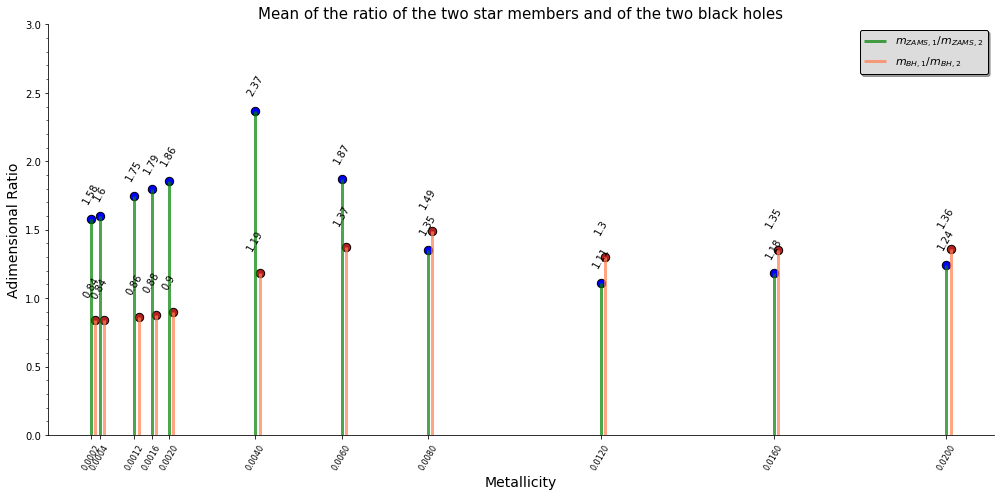

In [65]:
import warnings
warnings.filterwarnings('ignore')

frame_met_g1 = frame.groupby('metallicity')['colExt1:ratio_m1_m2_ZAMS'].agg([np.mean])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(14, 7))
ax.vlines(x=np.sort(frame['metallicity'].unique()), ymin=0, ymax = frame_met_g1['mean'],
        color = 'green', alpha = 0.7, linewidth = 3, label=r'$m_{ZAMS, 1}/m_{ZAMS, 2}$')
ax.scatter(x = np.sort(frame['metallicity'].unique()), y = frame_met_g1['mean'], s = 70, color = "blue", edgecolor='black')
for row in frame_met_g1.itertuples():
    ax.text(row.Index, row.mean+0.1, s = round(row.mean,2),
           horizontalalignment = 'center', verticalalignment='bottom', fontsize=10, rotation=60)           

frame_met_g2 = frame.groupby('metallicity')['colExt2:ratio_m1_m2_rem'].agg([np.mean])


           
ax.vlines(x=np.sort(frame['metallicity'].unique())+0.0001, ymin=0, ymax = frame_met_g2['mean'],
        color = 'coral', alpha = 0.7, linewidth = 3, label=r'$m_{BH, 1}/m_{BH, 2}$')
ax.scatter(x = np.sort(frame['metallicity'].unique())+0.0001, y = frame_met_g2['mean'], s = 70, color = "firebrick", edgecolor='black')
ax.set_xticks(frame['metallicity'].unique(), rotation=60)
ax.tick_params(axis='x', which='major', labelsize=8, rotation=60)
ax.minorticks_on()
ax.legend(prop={'weight':'bold','size':11}, loc='best', facecolor='gainsboro', edgecolor='black', shadow=True)
ax.set_xlabel('Metallicity', fontsize=14)
ax.set_ylabel('Adimensional Ratio', fontsize=14)
ax.set_title('Mean of the ratio of the two star members and of the two black holes', fontsize=15)
ax.set_ylim(top=3, bottom=0)
for row in frame_met_g2.itertuples():
    ax.text(row.Index, row.mean+0.15, s = round(row.mean,2),
           horizontalalignment = 'center', verticalalignment='bottom', fontsize=10, rotation=60)           
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.tight_layout()


In the plot above we can see that, at low metallicity, we have a remarkable difference between the mass ratio of the two stars and that of the two black holes. As the metallicity increases the difference narrows.
We can better understand this behaviour considering that at low metallicities stars lose a small amount of mass during their life due to stellar winds. This implies that when the Roche lobe overflow occurs, metal poor stars have more mass available that can be transferred to the companion.
This leads to mass flip and often the second star produces a black hole that is more massive than the one of the first star.

On the other hand, at high metallicities, stellar winds cause stars to loose mass faster. Therefore, even if the first star transfers mass to the second one through RLO, the latter looses this mass very easily, again, due to stellar winds and so leads to the formation of a low mass black hole. The mass ratio of the two black holes will be close to the one of the two starting stars.

# Conclusions

The goal of the project was to understand the relations between the features that characterize the evolution of a binary star system in the formation of a binary black hole, by looking at a dataset obtained from simulations.
In particular, we focused on searching which properties are more related to a specific behaviour in terms of formation process, so, in other words, on determining whether some specific characteristics drive the system to evolve mainly according to CE or Stable Mass Transfer. 

Running some machine learning algorithms (Random Forest and SVM), initially only on a part and then on the complete dataframe, we discovered that the features that have the highest impact on the fate of a BBH are, in descending order, the ratio between initial masses (**colExt1**), the ratio between final masses (**colExt2**) and the semi-major axis of the orbit (**col.7**).

These algorithms, applied to the full dataset, lead to the conclusion that the best classification is performed by **Random Forests**, with both **training error and test error around 0.9%**.

After this, we drawn some plots to compare with these intial results of ML: as expected, we found that features with high importance correspond to a clear separation when the data are plotted with respect to the formation process.

In the end we plotted the 2 most impactful characteristics, i.e. the initial and final mass ratio of the binary system, with respect to the metallicity value, in order to better understand the role of the metallicity in this process.

 # Reference
 
 Mapelli M. (2021) _Formation Channels of Single and Binary Stellar-Mass Black Holes_. In: Bambi C., Katsanevas S., Kokkotas K.D. (eds) Handbook of Gravitational Wave Astronomy. Springer, Singapore. https://doi.org/10.1007/978-981-15-4702-7_16-1